# Run CTD_ARIMA and CTD_TCN on simulated data

## Import and define hyperparameters

In [1]:
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import copy
import os
from statsmodels.tsa.arima.model import ARIMA

import util as util
import CTD_ARIMA
import CTD_TCN
import data_generator as gen

In [2]:

dataset_idx=15
diff=1
K = 5
M = 4
N = 1000
l_max = 6
T = 300
T_future = 5
lambda_rate = (M * (N + T) * np.log(N + T))/ (N * T)

AR_params = [[ 0., -0.5,  0.2,  0.,  0.2,  0.,   0.],
             [0.,  0.3,  -0.1,  0., 0,  0., 0.],
             [0., 0,   0,  0,  0.,  0.,  -0.6],
             [ 0., -0.05,   0.,   0., -0.4,  0.,  0.0],
             [0.,   0.2,  0.02, 0.2,  0.2,   0., 0.0],
             [0.,  0.1,  0. ,  0., 0.,    -.5,   -.1],
             [0.,  0.,  0.2,  0.5,  0.,  0., -0.],
            ]

centers = np.array([[0.,  1., 0.0,  1.],
                   [0.,  0., 2.,  1.],
                   [0., -1., 0.,  -1.],
                   [1.,  .0, -0.0, -1.],
                   [-1., -.0, -0.0,  0.]])

sigmas = (1/5) * np.array([[0.5 , 0.2, 1., 1.],
                             [0.5 , 0.2, 1., 1.],
                             [0.5 , 0.2, 1., 1.],
                             [0.5 , 0.2, 1., 1.],
                             [0.5 , 0.2, 1., 1.]])

## Select one of 16 cases

The default gives a dataset with larger observational noise, no missing entries, higher dimensional balance among columns of $X^*$, and large cluster distances relative the to size of the temporal embedding.

In [3]:

# Component 1: observational noise
Z_sd = 5. # Large noise
#Z_sd = 3. # Small noise

# Component 2: missing entries
#p_missing = 0.05 # 5% of entries missing 
p_missing = 0.00 # No missing entries

# Component 3: dimensional imbalance
#Small - keep current
#sigmas[:,2:] = (2/5) #large

# Component 4: Cluster distances
#close together - keep current
centers *= 5; sigmas *= 5 #Far away

## Generate dataset and explore $X^*$ and  $Y^*$

In [4]:

device = "cuda" if torch.cuda.is_available() else "cpu"
dataset_idx=15
data = gen.Simulate(N=N,T=T+T_future,
        tmp_params=np.array(AR_params)[:M,:].T, 
        centers=centers,
        Z_sd=Z_sd,
        sigmas=sigmas,
        p_missing=p_missing,
        difference=diff,
        seed=dataset_idx,
        AR_sd=0.2,
        torch_device=device)
data.generate()

<Figure size 640x480 with 0 Axes>

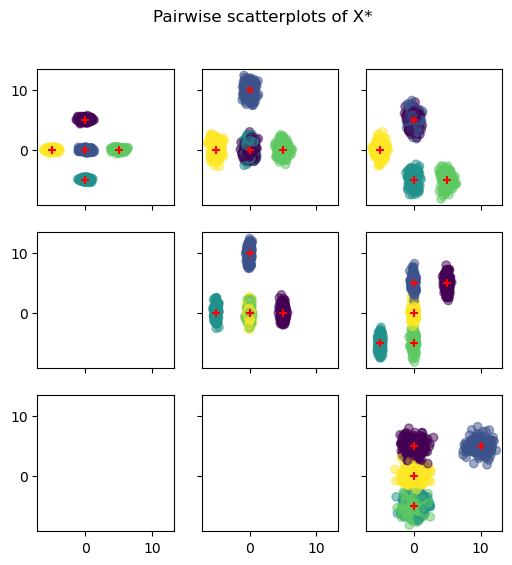

In [5]:
plt.clf()
X_np = data.X.detach().cpu().numpy()
new_centers = data.centers.detach().cpu().numpy()
fig, axes = plt.subplots(M-1, M-1, figsize=(6,6),
                        sharex=True, sharey=True)
for m1 in range(M):
    for m2 in range(M):
        if m1 < m2:
            axes[m1,m2-1].scatter(X_np[:,m1],X_np[:,m2], 
                                  c=data.labels, alpha=0.5)
            axes[m1,m2-1].scatter(new_centers[:,m1],new_centers[:,m2], 
                          color="red", marker="+")
fig.suptitle("Pairwise scatterplots of X*")
plt.show()

<Figure size 640x480 with 0 Axes>

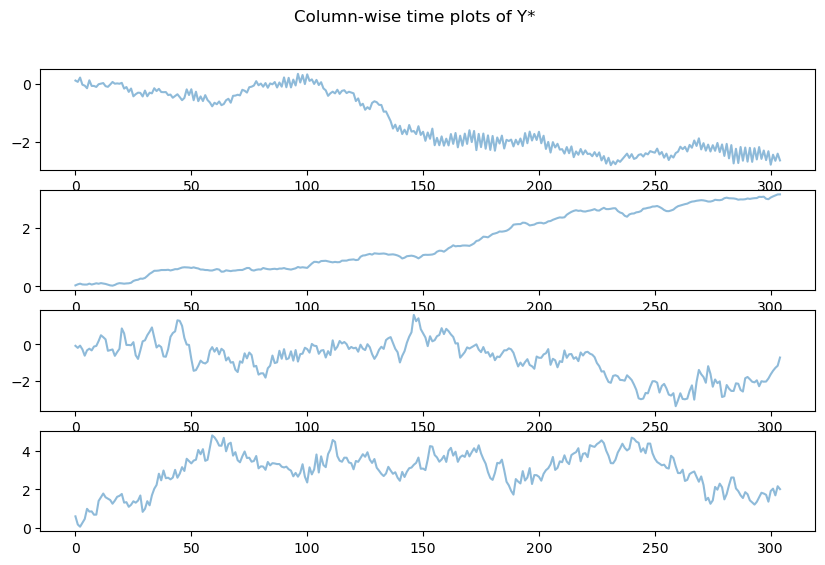

In [6]:
plt.clf()
fig,axes = plt.subplots(M, figsize=(10,6),sharey=False)
for m in range(M):
    axes[m].plot(data.Y[:,m].detach().cpu().numpy(), alpha=0.5)
fig.suptitle("Column-wise time plots of Y*")
plt.show()

## Run CTD

In [16]:
method = "GM-AR" #"GM-TCN"

if method == "GM-AR":
    fitter = CTD_ARIMA.CTD(Z_obs = data.Z_obs[:,:T],
                     AR_lags=torch.arange(l_max) + 1, 
                     difference=diff,
                     K = K, 
                     M = M,
                     rbsize=1000,
                     cbsize=300,
                     lambda_all = 1e-3 * lambda_rate,
                     lambda_x = 1e-3 * lambda_rate,
                     lambda_y = 1e-3 * lambda_rate,
                     lr=0.005,
                     verbosity=100,
                     seed=1234,
                     pre_patience=5,
                     patience=5,
                     device=device) 

if method == "GM-TCN":
    fitter = CTD_TCN.CTDTCN(Z_obs = data.Z_obs[:,:T],
                            lags=l_max,
                            K = K, 
                            M = M,
                            lambda_all = 1e-3 * lambda_rate,
                            lambda_x = 1e-3 * lambda_rate,
                            lambda_y = 1e-3 * lambda_rate,
                            lr=0.005,
                            verbosity=100,
                            seed=1234,
                            pre_patience=5,
                            patience=5,
                            device=device)

In [17]:
fitter.fit(noise=0.5)

## Pretraining done after loop 1272 | pretrain loss 24.738953385244805
Loop 100 | overall_loss 25.8214 | x 0.0004 | y 0.0001 
Loop 200 | overall_loss 24.82 | x 0.0004 | y 0.0001 
Training finished | loop 256
overall 24.7729 | x 0.0002 | y 0.0001


## Loss trajectories over iterations

<Figure size 640x480 with 0 Axes>

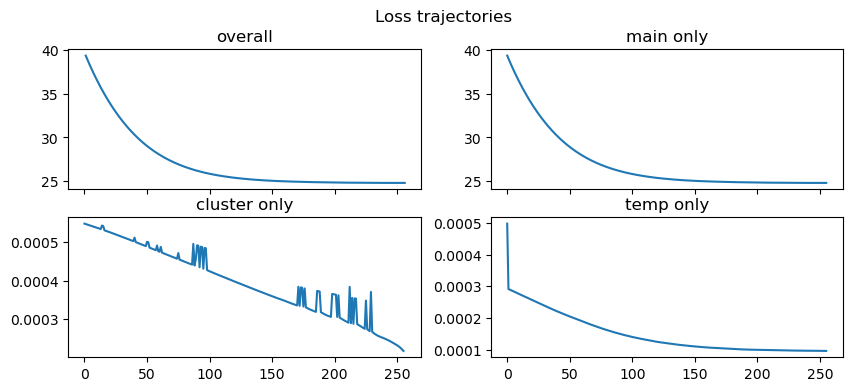

In [18]:
plt.clf()
fig, axes = plt.subplots(2, 2, figsize=(10,4), sharex=True)
axes[0,0].plot(np.array(fitter.overall_losses))
axes[0,0].set_title("overall")
axes[0,1].plot(np.array(fitter.overall_losses[1:])-np.array(fitter.cluster_regs))
axes[0,1].set_title("main only")
axes[1,0].plot(np.array(fitter.cluster_regs))
axes[1,0].set_title("cluster only")
axes[1,1].plot(np.array(fitter.temporal_regs))
axes[1,1].set_title("temp only")
fig.suptitle("Loss trajectories")
plt.show()

## View results

### 1. Cluster results
The printed metric is 1-Matching Rate (MR).

In [19]:
CTD_result = util.compute_cluster_performance(fitter.soft_labels, data.labels)  
c_results = util.compute_cluster_baselines(data.Z_obs[:,:T], M, data.labels, CTD_result=CTD_result,
                                     seed=dataset_idx, save_to=None)

c_results

,datetime,idx,CTD,GM
0,2025-06-02 15:19:58,15,0.007,0.002124


<Figure size 640x480 with 0 Axes>

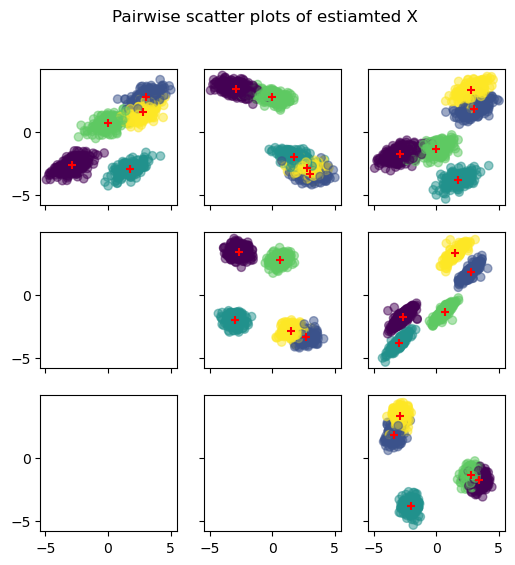

In [20]:
hard_labels =fitter.soft_labels.argmax(dim=1).detach().cpu().numpy()
plt.clf()
X_np = fitter.X.detach().cpu().numpy()
new_centers = fitter.centers.detach().cpu().numpy()
fig, axes = plt.subplots(M-1, M-1, figsize=(6,6),
                        sharex=True, sharey=True)
for m1 in range(M):
    for m2 in range(M):
        if m1 < m2:
            axes[m1,m2-1].scatter(X_np[:,m1],X_np[:,m2], 
                                  c=hard_labels, alpha=0.5)
            axes[m1,m2-1].scatter(new_centers[:,m1],new_centers[:,m2], 
                          color="red", marker="+")
plt.suptitle("Pairwise scatter plots of estiamted X")
plt.show()

### 2. Forecast error

In [22]:

hist_pred = fitter.Z_hat().detach().cpu().numpy()
alg_future = fitter.predict(T_future).detach().cpu().numpy()
util.compute_est_performance(pred=alg_future[:,:T_future], 
                         truth=data.Z_star[:, T:T+T_future], 
                         history=data.Z_star[:, :T],
                         method_name="CTD_forecast",
                         idx=dataset_idx,
                         types=["NRMSE", "SMAPE"],
                         save_to=None)

,method,datetime,idx,SMAPE,NRMSE
0,CTD_forecast,2025-06-02 15:20:10,15,0.325126,0.229122


### 3. History estimation error

In [23]:
util.compute_est_performance(pred=hist_pred, 
                         truth=data.Z_star[:, :T], 
                         history=data.Z_star[:, :T],
                         method_name="CTD_history",
                         idx=dataset_idx,
                         types=["NRMSE", "SMAPE"],
                         save_to=None)

,method,datetime,idx,SMAPE,NRMSE
0,CTD_history,2025-06-02 15:20:11,15,0.078185,0.031746
